## <span style='color:#ff5f27'> 📝 Imports</span>

In [2]:
!pip show pycocotools

Name: pycocotools
Version: 2.0.8
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages
Requires: matplotlib, numpy
Required-by: 


In [3]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## <span style='color:#ff5f27'> 🗄️ Data Loading</span>

In [36]:
coco = COCO('mc_coco/annotations/instances_val2017.json')
img_dir = 'mc_coco/val2017'

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [37]:
img = coco.imgs[47112]
img

{'license': 6,
 'file_name': '000000047112.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000047112.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-21 01:47:51',
 'flickr_url': 'http://farm9.staticflickr.com/8089/8463760032_37d63a2803_z.jpg',
 'id': 47112}

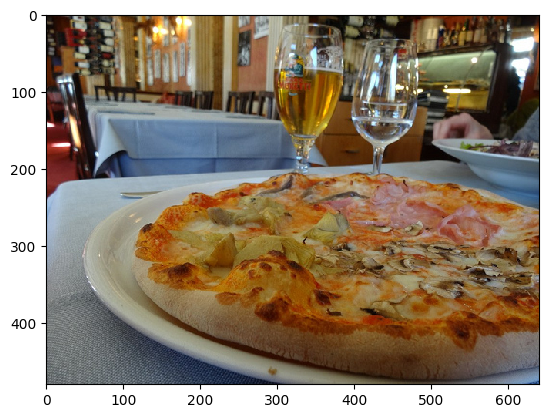

In [38]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

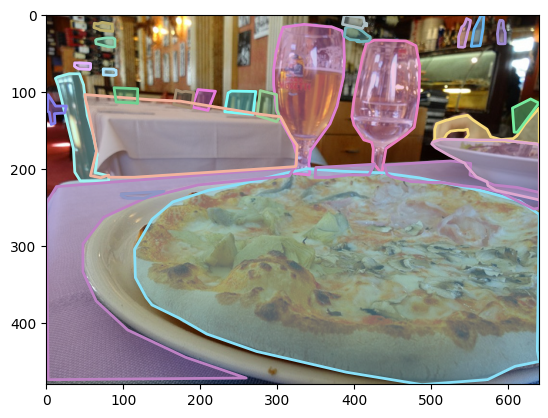

In [32]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

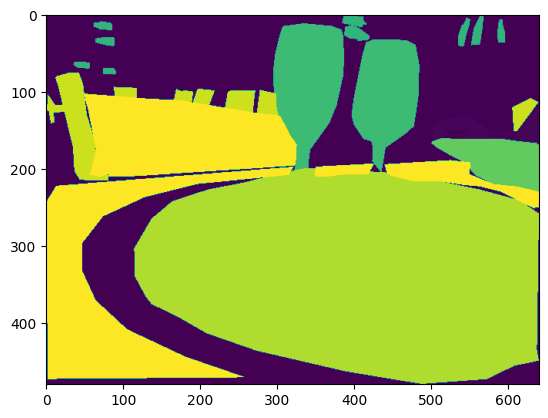

In [39]:
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
anns_img = np.zeros((img['height'],img['width']))
for ann in anns:
    anns_img = np.maximum(anns_img,coco.annToMask(ann)*ann['category_id'])
    
plt.imshow(anns_img)

---

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
from pycocotools.coco import COCO
from tqdm import tqdm


def plot_original_and_annotated(coco, img, img_dir):
    """
    Plot original image and annotated image side by side.
    
    Args:
    coco: COCO object
    img: Image metadata dictionary
    img_dir: Directory containing the images
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Original image
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax1.axis('off')
    
    # Annotated image
    ax2.imshow(image)
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    
    # Draw annotations manually
    polygons = []
    color = []
    for ann in anns:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        if 'segmentation' in ann:
            if type(ann['segmentation']) == list:
                # polygon
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    polygons.append(Polygon(poly))
                    color.append(c)
    
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax2.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax2.add_collection(p)
    
    ax2.set_title('Annotated Image', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_original_and_segmentation(coco, img, img_dir):
    """
    Plot original image and segmentation mask side by side.
    
    Args:
    coco: COCO object
    img: Image metadata dictionary
    img_dir: Directory containing the images
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Original image
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax1.axis('off')
    
    # Segmentation mask
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    anns_img = np.zeros((img['height'], img['width']))
    for ann in anns:
        anns_img = np.maximum(anns_img, coco.annToMask(ann) * ann['category_id'])
    
    ax2.imshow(anns_img)
    ax2.set_title('Segmentation Mask', fontsize=20)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


In [74]:
coco = COCO('mc_coco/annotations/instances_val2017.json')
img_dir = 'mc_coco/val2017'
seg_dir = 'mc_coco/val2017_segmentations'

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


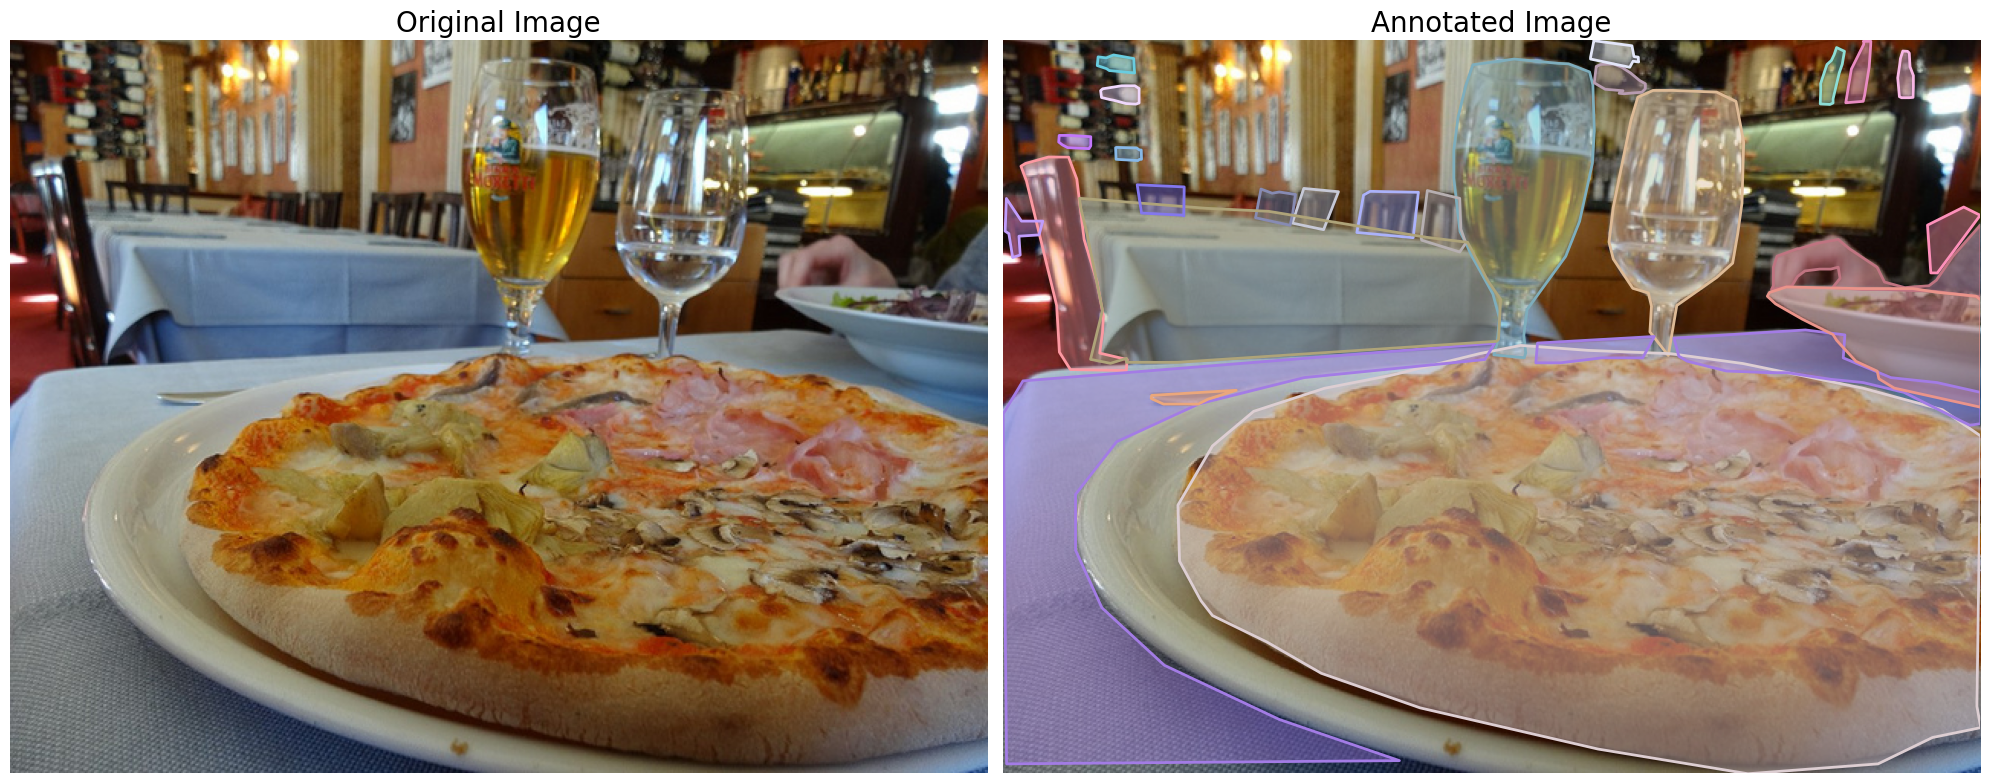

In [75]:
# For a single image:
img = coco.imgs[47112]
plot_original_and_annotated(coco, img, img_dir)

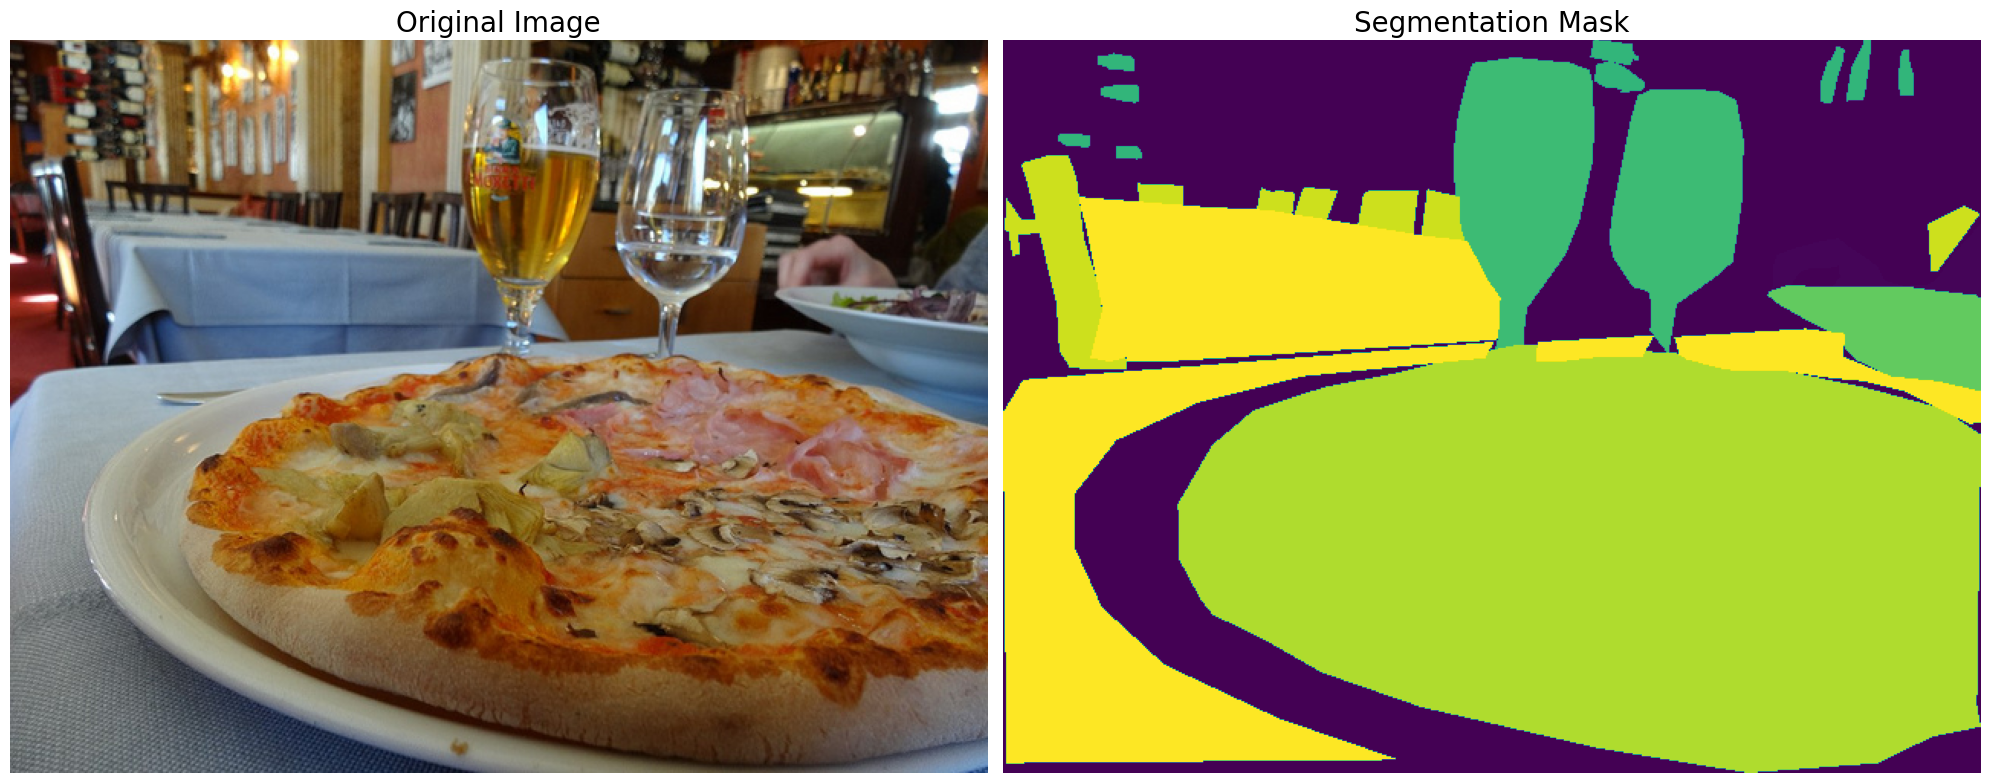

In [76]:
plot_original_and_segmentation(coco, img, img_dir)

In [84]:
import os
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_and_save_segmentation_masks(coco, img_dir, seg_dir, display_samples=False):
    """
    Iterate through each image, create a segmentation mask and save it as a colored image.
    
    Args:
    coco: COCO object
    img_dir: Directory containing the images
    seg_dir: Directory to save segmentation masks
    display_samples: If True, display some sample masks during processing
    """
    # Create segmentation directory if it doesn't exist
    os.makedirs(seg_dir, exist_ok=True)
    
    # Get total number of images
    total_images = len(coco.imgs)
    
    # Create a colormap
    cmap = plt.get_cmap('viridis')
    
    # Create tqdm progress bar
    with tqdm(total=total_images, desc="🧬 Creating segmentation masks") as pbar:
        for i, img_id in enumerate(coco.imgs):
            img = coco.imgs[img_id]
            
            # Create segmentation mask using the specified method
            cat_ids = coco.getCatIds()
            anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
            anns = coco.loadAnns(anns_ids)
            anns_img = np.zeros((img['height'], img['width']))
            for ann in anns:
                anns_img = np.maximum(anns_img, coco.annToMask(ann) * ann['category_id'])
            
            # Convert the mask to a colored image
            colored_mask = cmap(anns_img / anns_img.max())[:, :, :3]
            colored_mask = (colored_mask * 255).astype(np.uint8)
            
            # Display some sample masks
            if display_samples and i % 100 == 0:
                plt.figure(figsize=(10, 10))
                plt.imshow(colored_mask)
                plt.title(f"Segmentation mask for {img['file_name']}")
                plt.axis('off')
                plt.show()
            
            # Save colored segmentation mask
            seg_filename = os.path.splitext(img['file_name'])[0] + '_seg.png'
            seg_path = os.path.join(seg_dir, seg_filename)
            Image.fromarray(colored_mask).save(seg_path)
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({'⛳️ Current image': img['file_name']})
    
    print(f"✅ Completed! All colored segmentation masks saved in {seg_dir}")

# Usage example:
# coco = COCO('path/to/annotations.json')
# img_dir = 'path/to/images'
# seg_dir = 'path/to/segmentation_masks'
# 
# # Create and save segmentation masks for all images
# create_and_save_segmentation_masks(coco, img_dir, seg_dir, display_samples=True)

🧬 Creating segmentation masks:   0%|          | 0/5000 [00:00<?, ?it/s]

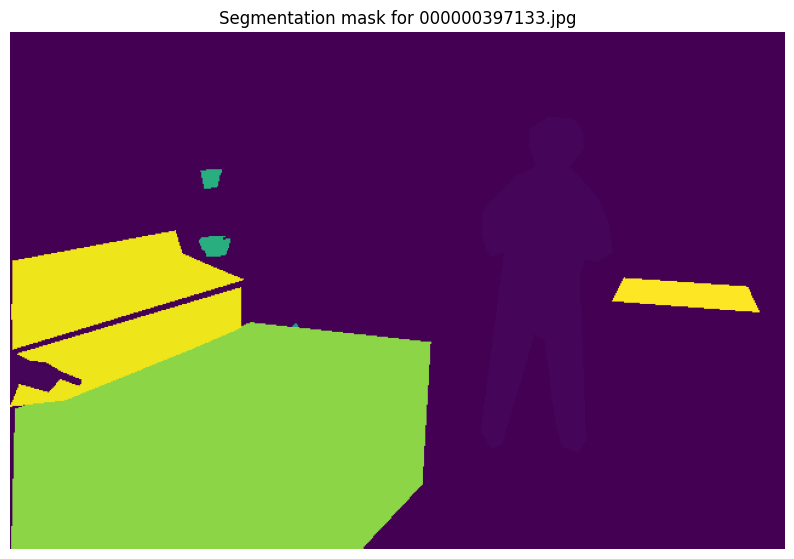

🧬 Creating segmentation masks:   0%|          | 9/5000 [00:03<32:25,  2.57it/s, ⛳️ Current image=000000458054.jpg]


KeyboardInterrupt: 

In [85]:
# For all images:
create_and_save_segmentation_masks(coco, img_dir, seg_dir, display_samples=True)

---